In [1]:
import pandas as pd
import numpy as np
import os
# from mootdx.quotes import Quotes
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# base_path = os.path.join('F:\stock', 'ETF')
base_path = 'ETF'

In [3]:
df_list = []
names = []
for path in os.listdir(base_path):
    names.append(path.split('.')[0])
    tmp_df = pd.read_csv(os.path.join(base_path, path))
    tmp_df['rate'] = tmp_df['close'] / tmp_df['pre_close'] - 1
    tmp_df['next_close'] = tmp_df['close'].shift(-1)
    tmp_df['buy_price'] = tmp_df['pre_close'].shift(-1)
    tmp_df['next_rate'] = tmp_df['rate'].shift(-1)

    # 计算信号值
    tmp_df['high_rate'] = tmp_df['high'] / tmp_df['close'] - 1
    tmp_df['low_rate'] = tmp_df['low'] / tmp_df['close'] - 1
    tmp_df['rate2'] = tmp_df['close'] / tmp_df['open'] - 1
    tmp_df['signal'] = 1 * tmp_df['high_rate'] + 3 * tmp_df['low_rate'] + 1 * tmp_df['rate2'] + 1 * tmp_df['rate']
    df_list.append(tmp_df)

In [5]:
df = pd.concat(df_list)

tmp_df = pd.DataFrame()
tmp_df['trade_date'] = sorted(df['trade_date'].unique())
index_df = pd.read_csv('000001.SH.csv')
tmp_df = tmp_df.merge(index_df[['trade_date', 'close']], on='trade_date', how='left')
tmp_df['rate2'] = tmp_df['close'] / tmp_df['close'][0]

df.dropna(inplace=True)
df

,trade_date,close,rate2
0,20110907,2516.0900,1.000000
1,20110908,2498.9430,0.993185
2,20110909,2497.7530,0.992712
3,20110913,2471.3050,0.982201
4,20110914,2484.8270,0.987575
...,...,...,...
2187,20200907,3292.5907,1.308614
2188,20200908,3316.4170,1.318084
2189,20200909,3254.6279,1.293526
2190,20200910,3234.8234,1.285655


In [6]:
df

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,amount,rate,next_close,buy_price,next_rate,high_rate,low_rate,rate2,signal
0,510900.SH,20121022,1.016,0.981,1.009,0.981,1.007,-0.009,-0.8858,3262105.43,326840.777,-0.008858,1.000,1.007,-0.006951,0.001986,-0.025819,0.026504,-0.057826
1,510900.SH,20121023,1.007,1.006,1.006,1.000,1.000,-0.007,-0.6951,218901.99,21925.165,-0.006951,0.999,1.000,-0.001000,0.006000,0.000000,-0.005964,-0.006916
2,510900.SH,20121024,1.000,0.997,1.006,0.996,0.999,-0.001,-0.1000,368428.55,36868.305,-0.001000,0.998,0.999,-0.001001,0.007007,-0.003003,0.002006,-0.000996
3,510900.SH,20121025,0.999,0.998,1.005,0.997,0.998,-0.001,-0.1001,223936.99,22408.775,-0.001001,0.987,0.998,-0.011022,0.007014,-0.001002,0.000000,0.003007
4,510900.SH,20121026,0.998,1.000,1.000,0.982,0.987,-0.011,-1.1022,148478.00,14708.607,-0.011022,0.994,0.987,0.007092,0.013171,-0.005066,-0.013000,-0.026048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,512010.SH,20200904,2.901,2.848,2.866,2.812,2.853,-0.048,-1.6546,303358.69,85922.759,-0.016546,2.760,2.853,-0.032597,0.004557,-0.014371,0.001756,-0.053346
1675,512010.SH,20200907,2.853,2.838,2.862,2.756,2.760,-0.093,-3.2597,322391.53,90419.055,-0.032597,2.776,2.760,0.005797,0.036957,-0.001449,-0.027484,-0.027473
1676,512010.SH,20200908,2.760,2.763,2.787,2.743,2.776,0.016,0.5797,199198.00,55122.611,0.005797,2.652,2.776,-0.044669,0.003963,-0.011888,0.004705,-0.021198
1677,512010.SH,20200909,2.776,2.732,2.732,2.620,2.652,-0.124,-4.4669,392963.00,104743.587,-0.044669,2.650,2.652,-0.000754,0.030166,-0.012066,-0.029283,-0.079984


In [5]:
init_money = 100000
market_value = init_money
left_money = init_money
service_rate = 0.00005
values = []
hold_num = dict(zip(df['ts_code'].unique(), np.zeros(df['ts_code'].nunique())))
next_closes = dict(zip(df['ts_code'].unique(), np.zeros(df['ts_code'].nunique())))
market_values_ = [init_money]
k = 0
for i,g in tqdm(df.groupby('trade_date')):
    k+=1

    g = g.reset_index(drop=True)
    signal = g['signal'].values

    # 根据信号值进行仓位的分配（信号值越大 仓位分配的越多）
    tmp = -1e-2
    idx = np.where(signal<tmp)[0]
    signal[idx] = tmp
    tmp = signal - min(signal)
    cangwei = tmp / (tmp.sum()+1e-6)  
    
    cangwei = np.round(cangwei,2)

    nums = []
    left_money = market_value
    for j in range(len(g)):
        money = (market_value-100) * cangwei[j]
        num = money / g['buy_price'][j] // 100
        nums.append(num)
        left_money = left_money - num * 100 * g['buy_price'][j] * (1+service_rate)
        hold_num[g['ts_code'][j]] = num
        next_closes[g['ts_code'][j]] = g['next_close'][j]

    # 计算市值
    market_value = 0
    for key in hold_num:
        market_value = market_value + hold_num[key] * 100 * next_closes[key] * (1-service_rate)
        hold_num[key] = 0
    market_value += left_money
    market_values_.append(market_value)

100%|██████████| 2191/2191 [00:00<00:00, 2944.36it/s]


In [6]:
market_value

504281.7790049566

In [7]:
tmp_df['market_value'] = market_values_
tmp_df['rate1'] = tmp_df['market_value'] / init_money

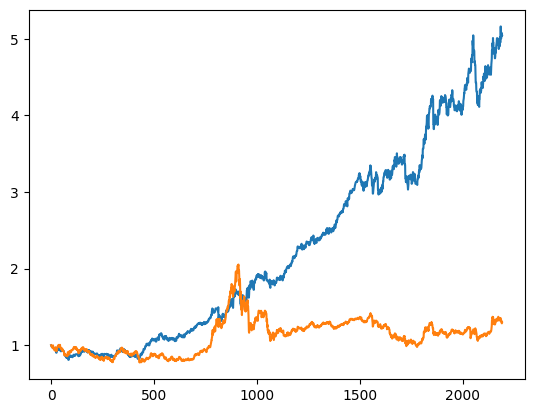

In [8]:
plt.figure()
plt.plot(tmp_df['rate1'])
plt.plot(tmp_df['rate2'])
plt.show()